In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import color, io
from skimage.filters import threshold_otsu
import itertools
from PIL import Image

In [2]:
def print_cuts(orig_image, pix_mean, cuts):
    ig, axes = plt.subplots(ncols=3, figsize=(20, 2.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].plot(pix_mean)
    ax[1].set_title('Mean Pixel Count')

    ax[2].imshow(orig_image, cmap=plt.cm.gray)
    ax[2].set_title('Cuts')
    for x in cuts:
        ax[2].axvline(x, color='r')

In [3]:
def get_cuts(image, print_result=False):
    '''
    Get an image and returns a list of x coordinate in which the image could be cut 
    without going through any pictorial elements.
    '''
    #convert to gray scale and seperate between black and white pixels
    image = color.rgb2gray(image)
    thresh = threshold_otsu(image)
    binary = image > thresh
    
    #mean of black pixes in every column
    H = binary.shape[0]
    W = binary.shape[1]
    take = int(H * 0.05) #ignore top and bottom frame
    pix = np.invert(binary)[take:H-take,:].mean(axis=0)

    #look for local minima
    argmin = np.argsort(pix)
    min_pts = {idx : val for val, idx in zip(pix[argmin], argmin)}

    cuts = set()
    for k in min_pts:
        if min_pts[k] > 0.04:
            break
        
        #not in edges
        if k < int(W * 0.15) or k > int(W - (W * 0.15)):
            continue
        
        #local minimum
        skip = False  
        cuts_copy = cuts
        for cut in cuts:
            if (k - cut) < int(W * 0.15):
                if min_pts[k] < min_pts[cut]:
                    cuts_copy.remove(cut)
                else:
                    skip = True
                break
        
        cuts = cuts_copy
        if skip == True:
            continue
            
        cuts.add(k)
    
    if print_result:
        print_cuts(image, pix, cuts)
        
    return cuts

In [4]:
def get_pic_permutations(image, cuts):
    '''
    Get a list of x cooridante in which an image could be cut and returns a list of all posibble 
    permutations of image tiles.
    A permutation is a dictionary of tile#: (tile_begin, tile_end)
    '''
    if len(cuts) == 0:
        return [{0 : (0, image.shape[1] - 1)}]
    
    #cuts to image tiles 
    tiles = {}
    begin = 0
    for i, cut in enumerate(sorted(cuts)):
        tiles[i] = (begin,cut)
        begin = cut + 1
    tiles[i + 1] = (begin, image.shape[1] - 1)
    
    #get all tiles permutations
    permutations = []
    for per in itertools.permutations(tiles, len(tiles)):
        ordering = {}
        for tile in per:
            ordering[tile] = tiles[tile]
        permutations.append(ordering)
    
    return permutations

In [5]:
def create_permutated_images(image, permutations, print_permutations=True):
    '''
    Get an image and a list of permutations.
    Returns a list of tuples (permutation name, permutated image).
    '''
    #no possible permutations for image
    if len(permutations) == 1:
        return []
    
    orig_image = Image.fromarray(image)
    
    #create permutated images, skip first one which is identity
    permutated_images = []
    height = orig_image.height - 1
    for i in range(1, len(permutations)):   
        regions = []
        y = 0
        for tile in permutations[i]:
            (x, width) = permutations[i][tile]
            region = orig_image.crop((x, y, width, height))
            regions.append(region)

        permutated = Image.new(mode="RGB", size=orig_image.size)
        #paste tiles in target location
        x = y = 0
        for region in regions:
            permutated.paste(region, (x, y))
            x += region.width
        permutated_image_name = list(permutations[i].keys())
        permutated_images.append((permutated_image_name, permutated))
    
    if print_permutations:
        #print original
        ncols = len(permutated_images) + 1
        ig, axes = plt.subplots(ncols=ncols, figsize=(20, 2.5))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, ncols, 1)
        ax[0].imshow(orig_image, cmap=plt.cm.gray)
        ax[0].set_title('Original')
        
        for i in range(1, ncols):
            ax[i] = plt.subplot(1, ncols, i + 1)
            ax[i].set_title(permutated_images[i-1][0])
            ax[i].imshow(permutated_images[i-1][1], cmap=plt.cm.gray)
            
    return permutated_images

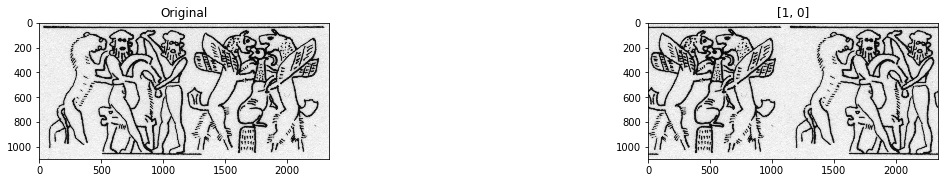

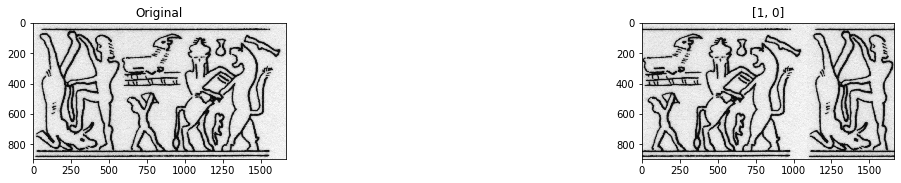

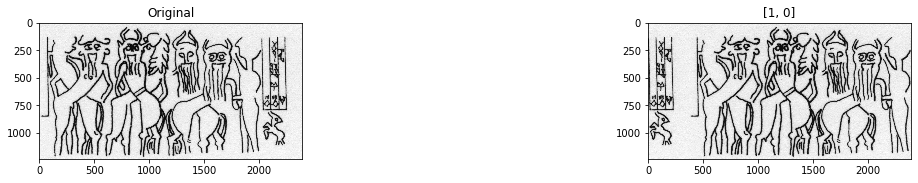

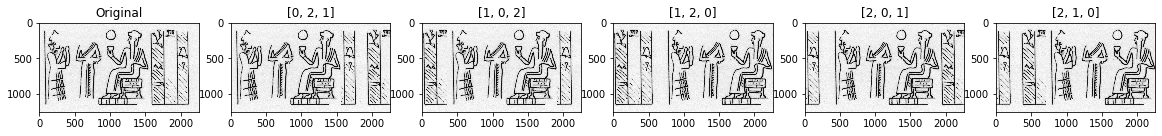

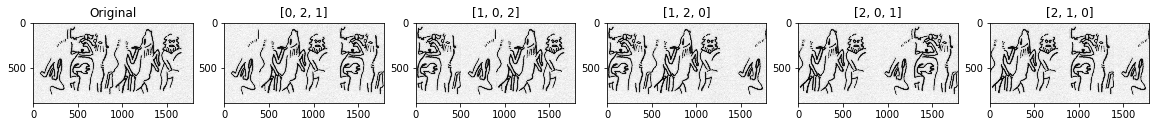

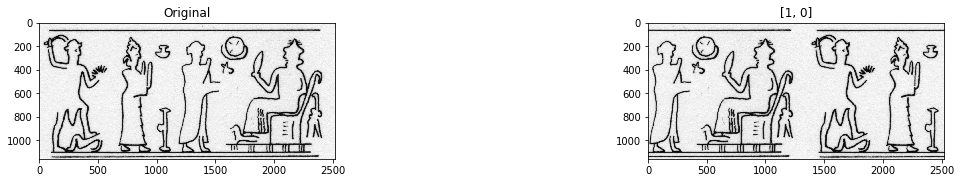

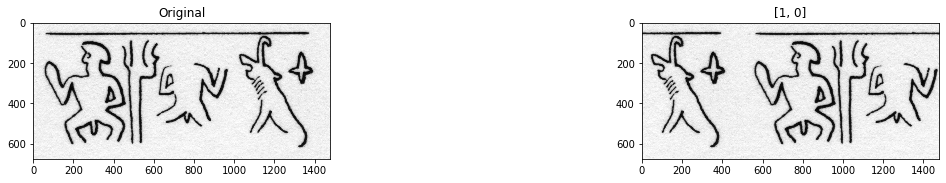

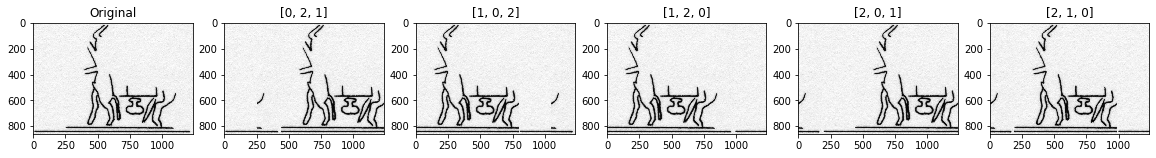

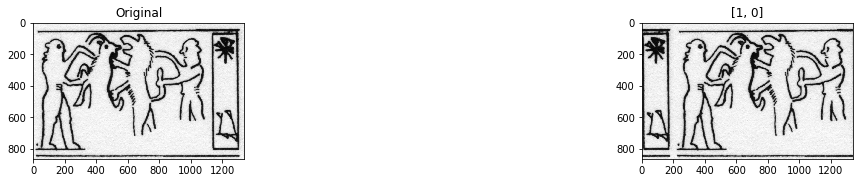

In [6]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/pics'

labels = pd.read_csv(label_file)

permutations = pd.DataFrame()
count = 1
for idx in range(len(labels)):
    if labels.loc[idx, "category"] != 'drawing':
        continue
    
    img_name = os.path.join(pic_dir, labels.loc[idx, "img_name"])
    image = io.imread(img_name)
    
    cuts = get_cuts(image, False)

    permutations = get_pic_permutations(image, cuts)
    
    create_permutated_images(image, permutations, False)
    
    #labels = np.array(self.labels_frame.iloc[idx, 2:])
    if count == 10:
        break
    count +=1